In [135]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
import math

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import SubAttr
from lib.models import MLP
from lib.data import small_CUB, CUB, SubColumn
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap, show_attribution
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird, attribute2idx

# concept models for independent concepts

# images: 11780
filename: /data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/174.Palm_Warbler/Palm_Warbler_0046_169837.jpg
image id: 10206
class id: 174
bird name: 174.Palm_Warbler
is_test: 1
image size: (456, 500, 3)


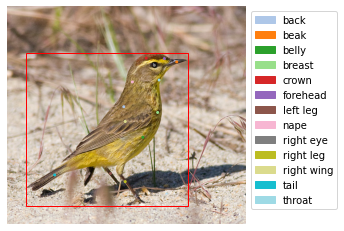

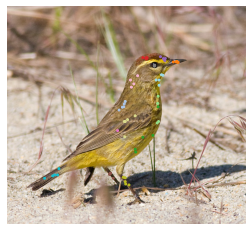

--------------- represented in dataset
image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


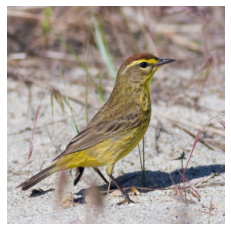

In [92]:
cub = CUB()
print('# images:', len(cub)) # should be 11788 - 8 (-8 b/c 8 gray scale images)

train_indices = [i for i in range(len(cub)) if not is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
test_indices = [i for i in range(len(cub)) if is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
cub_train = Subset(cub, train_indices)
cub_test = Subset(cub, test_indices)

def show_cub_data(dataset, idx):
    filename = dataset[idx]['filename']
    describe_bird(filename)

    print('--------------- represented in dataset')
    im, y = dataset[idx]['x'].permute(1,2,0), dataset[idx]['y'] 
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()
    
show_cub_data(cub_test, 30)

has_upperparts_color::brown


Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0
train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 70.8%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 4.095e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 3.511e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 3.263e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 2.810e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 2.459e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 2.328e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 2.077e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 1.756e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 1.408e-01


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch   9: loss 1.324e-01


test eval: 100%|██████████| 181/181 [00:16<00:00, 11.05it/s]
Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc after training: 89.2%
has_primary_color::black


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 72.8%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 3.894e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 3.079e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 2.735e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 2.491e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 2.096e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 1.803e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 1.648e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 1.487e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 1.192e-01


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch   9: loss 1.069e-01


test eval: 100%|██████████| 181/181 [00:16<00:00, 11.08it/s]
Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc after training: 89.7%
has_shape::perching-like


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 41.6%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 4.358e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 3.250e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 2.804e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 2.433e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 1.928e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 1.863e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 1.786e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 1.066e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 9.397e-02


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch   9: loss 9.930e-02


test eval: 100%|██████████| 181/181 [00:16<00:00, 11.03it/s]
Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc after training: 86.8%
has_forehead_color::blue


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 26.9%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 1.352e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 1.122e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 1.057e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 9.590e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 9.108e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 8.305e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 7.331e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 6.958e-02


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 6.247e-02


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch   9: loss 4.773e-02


test eval: 100%|██████████| 181/181 [00:16<00:00, 10.97it/s]
Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc after training: 97.6%
has_back_color::grey


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 31.2%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 5.192e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 4.923e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 4.664e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 4.519e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 4.190e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 3.961e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 3.738e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 3.542e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 3.361e-01


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch   9: loss 3.158e-01


test eval: 100%|██████████| 181/181 [00:16<00:00, 10.88it/s]
Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc after training: 82.0%
has_size::very_small_(3_-_5_in)


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 89.1%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 3.000e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 3.019e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 2.895e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 2.778e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 2.784e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 2.694e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 2.627e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 2.643e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 2.702e-01


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch   9: loss 2.684e-01


test eval: 100%|██████████| 181/181 [00:16<00:00, 10.88it/s]
Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc after training: 92.4%
has_primary_color::yellow


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 14.7%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 2.350e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 1.924e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 1.763e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 1.572e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 1.556e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 1.876e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 1.418e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 1.304e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 1.357e-01


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch   9: loss 1.234e-01


test eval: 100%|██████████| 181/181 [00:16<00:00, 10.90it/s]
Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc after training: 94.9%
has_back_color::white


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 76.1%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 3.327e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 3.017e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 2.933e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 2.393e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 2.317e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 2.077e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 1.826e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 1.740e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 1.646e-01


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch   9: loss 1.535e-01


test eval: 100%|██████████| 181/181 [00:16<00:00, 10.85it/s]
Using cache found in /home/jiaxuan/.cache/torch/hub/pytorch_vision_v0.9.0


task acc after training: 94.0%
has_back_pattern::solid


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

task acc before training: 46.5%


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   0: loss 6.439e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   1: loss 6.121e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   2: loss 5.670e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   3: loss 5.411e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   4: loss 5.173e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   5: loss 4.825e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   6: loss 4.589e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   7: loss 4.187e-01


train step for 1 epoch:   0%|          | 0/188 [00:00<?, ?it/s]

epoch   8: loss 3.758e-01


test eval:   0%|          | 0/181 [00:00<?, ?it/s]

epoch   9: loss 3.307e-01


test eval: 100%|██████████| 181/181 [00:16<00:00, 10.91it/s]


task acc after training: 72.8%


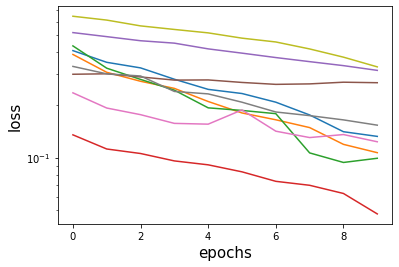

In [3]:
# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

ind_maj_attr = [
     'has_upperparts_color::brown',
     'has_primary_color::black',
     'has_shape::perching-like',
     'has_forehead_color::blue',
     'has_back_color::grey',
     'has_size::very_small_(3_-_5_in)',
     'has_primary_color::yellow',
     'has_back_color::white',
     'has_back_pattern::solid']

def concept_model(loader_xy, loader_xy_te, n_epochs=10, report_every=1, plot=True, device='cuda'):
    # regular model
    net = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
    net.fc = nn.Linear(2048, 2) # concept binary model
    net.to(device)
    print('task acc before training: {:.1f}%'.format(test(net, loader_xy, acc_criterion, device=device) * 100))
    
    # train
    opt = optim.Adam(net.parameters()) # optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, device=device)
    if plot: plot_log(log)
    print('task acc after training: {:.1f}%'.format(test(net, loader_xy_te, acc_criterion, device=device) * 100))
    return net


models = []
for attr in ind_maj_attr:
    print(attr)
    loader_xy_ = DataLoader(SubColumn(SubAttr(cub_train, attr), ['x', 'attr']), batch_size=32, shuffle=True, num_workers=8)
    loader_xy_te_ = DataLoader(SubColumn(SubAttr(cub_test, attr), ['x', 'attr']), batch_size=32, shuffle=False, num_workers=8)
    models.append(concept_model(loader_xy_, loader_xy_te_, n_epochs=10, report_every=1))

# Visualization of the concepts

0-indexed class id (describe bird is 1-indexed): 173


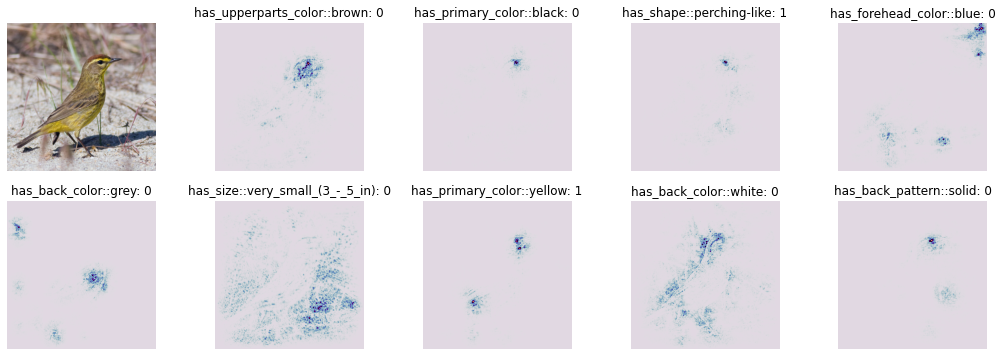

In [138]:
show_attribution(cub_test, models, ind_maj_attr, 30, explain_method=lambda model: IntegratedGradients(model, steps=10))

0-indexed class id (describe bird is 1-indexed): 173


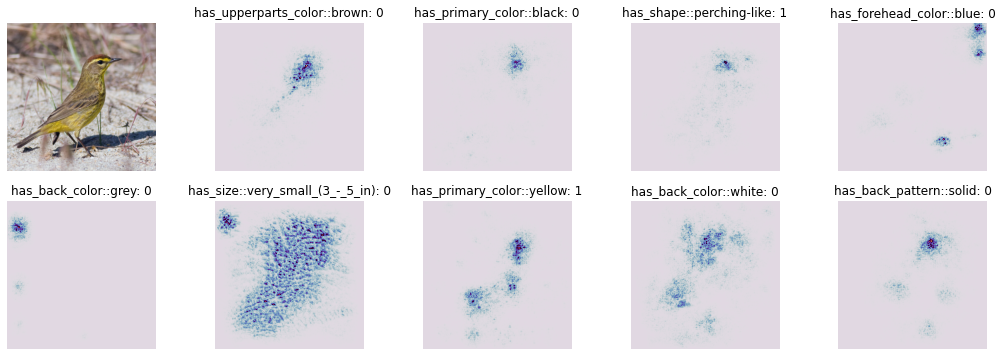

In [139]:
show_attribution(cub_test, models, ind_maj_attr, 30)

0-indexed class id (describe bird is 1-indexed): 193


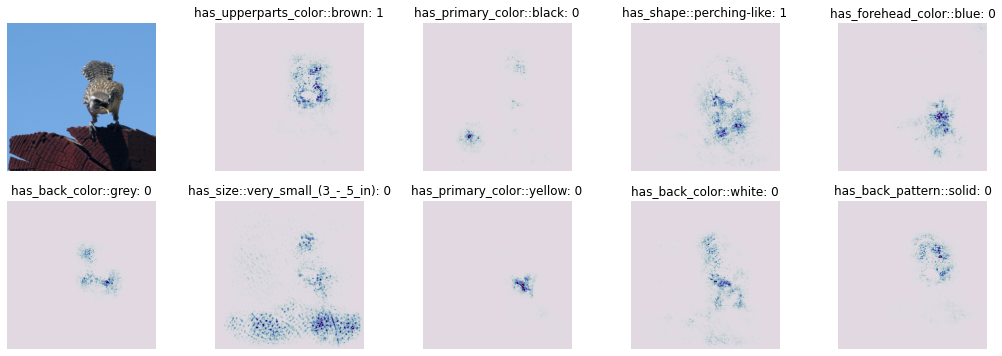

In [133]:
show_attribution(cub_test, models, ind_maj_attr, 150, explain_method=lambda model: IntegratedGradients(model, steps=10))

0-indexed class id (describe bird is 1-indexed): 193


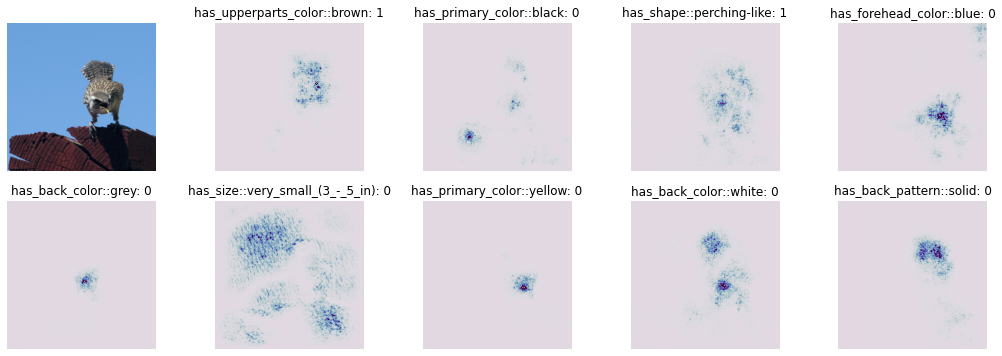

In [140]:
show_attribution(cub_test, models, ind_maj_attr, 150)